In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections.abc import Callable
from enum import Enum
from mpl_toolkits.mplot3d import Axes3D

In [2]:
@dataclass
class Equation:
    a : float = 0.
    b: float = 0.
    c: float = 0.
    f: Callable = lambda x, y: 0.
    alpha_1: float = 0.
    beta_1: float = 1.
    alpha_2: float = 0.
    beta_2: float = 1.
    alpha_3: float = 0.
    beta_3: float = 1.
    alpha_4: float = 0.
    beta_4: float = 1.
    phi_1: Callable = lambda y: 0.
    phi_2: Callable = lambda y: 0.
    phi_3: Callable = lambda x: 0.
    phi_4: Callable = lambda x: 0.

class Methods(Enum):
    ITERETION = 1   # простые итерации
    SEIDEL = 2      # метод Зейделя
    RELAXATION = 3  # верхняя релаксация

class Traversal(Enum):
    RIGHT_DOWN = 0
    LEFT_DOWN = 1
    LEFT_UP = 2
    RIGHT_UP = 3
    
    def __int__(self):
        return self.value

In [3]:
def interpolate_linearly(start_val, end_val, num_points):
    return np.linspace(start_val, end_val, num_points)

def interpolate_2d_matrix(res):
    n, m = res.shape

    if res[0, 1:-1].any() and res[1:-1, 0].any():
      for i in range(1, n):
        for j in range(1, m):
          res[i, j] = interpolate_linearly(res[0, j], res[i, 0], i + 1 + j + 1 - 1)[i]
    elif res[0, 1:-1].any() and res[1:-1, -1].any():
      for i in range(1, n):
        for j in range(0, m - 1):
          res[i, j] = interpolate_linearly(res[0, j], res[i, -1], i + 1 + (m - j) - 1)[i]
    elif res[-1, 1:-1].any() and res[1:-1, -1].any():
      for i in range(0, n - 1):
        for j in range(0, m - 1):
          res[i, j] = interpolate_linearly(res[-1, j], res[i, -1], (n - i) + (m - j) - 1)[n - i - 1]
    elif res[-1, 1:-1].any() and res[1:-1, 0].any():
      for i in range(0, n - 1):
        for j in range(1, m):
          res[i, j] = interpolate_linearly(res[-1, j], res[i, 0], (n - i) + j + 1 - 1)[n - i - 1]
    elif res[0, 1:-1].any() or res[-1, 1:-1].any():
      for j in range(m):
          res[1:-1, j] = interpolate_linearly(res[0, j], res[-1, j], n)[1:-1]
    elif res[1:-1, 0].any() or res[1:-1, -1].any():
      for i in range(n):
        res[i, 1:-1] = interpolate_linearly(res[i, 0], res[i, -1], m)[1:-1]
    return res

def sign(x):
  return int(x > 0) - int(x < 0)

def diff(A, B):
    diff = A - B
    return np.sqrt(np.sum(diff ** 2))

In [4]:
def finite_difference(
    x_range: tuple[float, float],
    y_range: tuple[float, float],
    h_x: float,
    h_y: float,
    eq: Equation,
    interpolate: bool = True,
    method: Methods = Methods.ITERETION,
    theta: float = 1.,
    eps: float = 1e-3,
    direction: Traversal = Traversal.LEFT_UP, 
) -> np.ndarray:
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    n = len(x)
    m = len(y)
    if method == Methods.SEIDEL:
       theta = 1.

    res = np.zeros((n, m)) 
    for cur_y_id in range(m):
        if eq.alpha_1 == 0:
          res[0][cur_y_id] = 1 / eq.beta_1 * eq.phi_1(y[cur_y_id])
        if eq.alpha_2 == 0:
          res[-1][cur_y_id] = 1 / eq.beta_2 *  eq.phi_2(y[cur_y_id])

    for cur_x_id in range(n):
        if eq.alpha_3 == 0:
          res[cur_x_id][0] = 1 / eq.beta_3 * eq.phi_3(x[cur_x_id])
        if eq.alpha_4 == 0:
          res[cur_x_id][-1] = 1 / eq.beta_4 * eq.phi_4(x[cur_x_id])

    if interpolate == True:
      interpolate_2d_matrix(res)

    iters = 1
    while True:
      res_prev = res
      res = np.zeros((n, m))
      for cur_y_id in range(m):
          if abs(eq.alpha_1) < eps:
            res[0][cur_y_id] = 1 / eq.beta_1 * eq.phi_1(y[cur_y_id])
          if abs(eq.alpha_2) < eps:
            res[-1][cur_y_id] = 1 / eq.beta_2 * eq.phi_2(y[cur_y_id])
      for cur_x_id in range(n):
          if abs(eq.alpha_3) < eps:
            res[cur_x_id][0] = 1 / eq.beta_3 * eq.phi_3(x[cur_x_id])
          if abs(eq.alpha_4) < eps:
            res[cur_x_id][-1] = 1 / eq.beta_4 * eq.phi_4(x[cur_x_id])

      traversing_information = [ (1, n - 2, 1, m - 2), (1, n - 2, m - 2, 1), (n - 2, 1, m - 2, 1), (n - 2, 1, 1, m - 2) ] 
      index_of_traversing = int(direction)
      x_start, x_end, y_start, y_end = traversing_information[index_of_traversing]
      x_dir = sign(x_end - x_start)
      y_dir = sign(y_end - y_start)

      uij_coeff = (eq.c - 2 / h_x**2 - 2 / h_y**2)
      for cur_x_id in range(x_start, x_end + x_dir, x_dir):
        for cur_y_id in range(y_start, y_end + y_dir, y_dir):
          if method == Methods.ITERETION:
            part_d2u_dx2 = 1 / h_x**2 * (res_prev[cur_x_id + x_dir][cur_y_id] + res_prev[cur_x_id - x_dir][cur_y_id])
            part_d2u_dy2 = 1 / h_y**2 * (res_prev[cur_x_id][cur_y_id + y_dir] + res_prev[cur_x_id][cur_y_id - y_dir])
            du_dx = eq.a / (2 * h_x) * (res_prev[cur_x_id + x_dir][cur_y_id] - res_prev[cur_x_id - x_dir][cur_y_id])
            du_dy = eq.b / (2 * h_y) * (res_prev[cur_x_id][cur_y_id + y_dir] - res_prev[cur_x_id][cur_y_id - y_dir])

            res[cur_x_id][cur_y_id] = 1 / uij_coeff * (eq.f(x[cur_x_id], y[cur_y_id]) - (part_d2u_dx2 + part_d2u_dy2 + du_dx + du_dy))

          elif method in [Methods.SEIDEL, Methods.RELAXATION]:
            part_d2u_dx2 = 1 / h_x**2 * (res_prev[cur_x_id + x_dir][cur_y_id] + res[cur_x_id - x_dir][cur_y_id])
            part_d2u_dy2 = 1 / h_y**2 * (res_prev[cur_x_id][cur_y_id + y_dir] + res[cur_x_id][cur_y_id - y_dir])
            du_dx = eq.a / (2 * h_x) * (res_prev[cur_x_id + x_dir][cur_y_id] - res[cur_x_id - x_dir][cur_y_id])
            du_dy = eq.b / (2 * h_y) * (res_prev[cur_x_id][cur_y_id + y_dir] - res[cur_x_id][cur_y_id - y_dir])

            res[cur_x_id][cur_y_id] = (theta * (1 / uij_coeff * (eq.f(x[cur_x_id], y[cur_y_id]) - (part_d2u_dx2 + part_d2u_dy2 + du_dx + du_dy))) +
                                        (1 - theta) * res_prev[cur_x_id][cur_y_id])

      for cur_y_id in range(1, m - 1):
        if eq.alpha_1 != 0:
          u0j_coef = 2 * h_x * eq.beta_1 - 3 * eq.alpha_1
          res[0][cur_y_id] = 1 / u0j_coef * (2 * h_x * eq.phi_1(y[cur_y_id]) - eq.alpha_1 * (4 * res[1][cur_y_id] - res[2][cur_y_id]))
        if eq.alpha_2 != 0:
          unj_coeff = 2 * h_x * eq.beta_2 + 3 * eq.alpha_2
          res[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * eq.phi_2(y[cur_y_id]) + eq.alpha_2 * (4 * res[-2][cur_y_id] - res[-3][cur_y_id]))

      for cur_x_id in range(1, n - 1):
        if eq.alpha_3 != 0:
          ui0_coef = 2 * h_y * eq.beta_3 - 3 * eq.alpha_3
          res[cur_x_id][0] = 1 / ui0_coef * (2 * h_y * eq.phi_3(x[cur_x_id]) - eq.alpha_3 * (4 * res[cur_x_id][1] - res[cur_x_id][2]))
        if eq.alpha_4 != 0:
          uim_coeff = 2 * h_y * eq.beta_4 + 3 * eq.alpha_4
          res[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * eq.phi_4(x[cur_x_id]) + eq.alpha_4 * (4 * res[cur_x_id][-2] - res[cur_x_id][-3]))

      if diff(res, res_prev) < eps:
        break
      iters += 1
    return res, iters

def analytic(u, l_x, l_y, h_x, h_y):
    x = np.arange(0, l_x, h_x)
    y = np.arange(0, l_y, h_y)
    res = []
    for xi in x:
        res.append([u(xi, yi) for yi in y])
    return np.array(res)

In [5]:
eq = Equation()
eq.alpha_1 = 1
eq.beta_1 = 0
eq.alpha_3 = 1
eq.beta_3 = 0
eq.f = lambda x, y: 0
eq.phi_1 = lambda y: 0
eq.phi_2 = lambda y: 1 - y ** 2
eq.phi_3 = lambda x: 0
eq.phi_4 = lambda x: x ** 2 - 1

N = 70
K = 70
l_x = 1
l_y = 1
eps = 0.005

iter, n1 = finite_difference((0, l_x), (0, l_y), l_x / N, l_y / K, eq, method=Methods.ITERETION, eps=eps)
seidel, n2 = finite_difference((0, l_x), (0, l_y), l_x / N, l_y / K, eq, method=Methods.SEIDEL, eps=eps)
relax, n3 = finite_difference((0, l_x), (0, l_y), l_x / N, l_y / K, eq, method=Methods.RELAXATION, theta=1.5, eps=eps)
u = analytic(lambda x, y: x ** 2 - y ** 2, l_x, l_y, l_x / N, l_y / K)

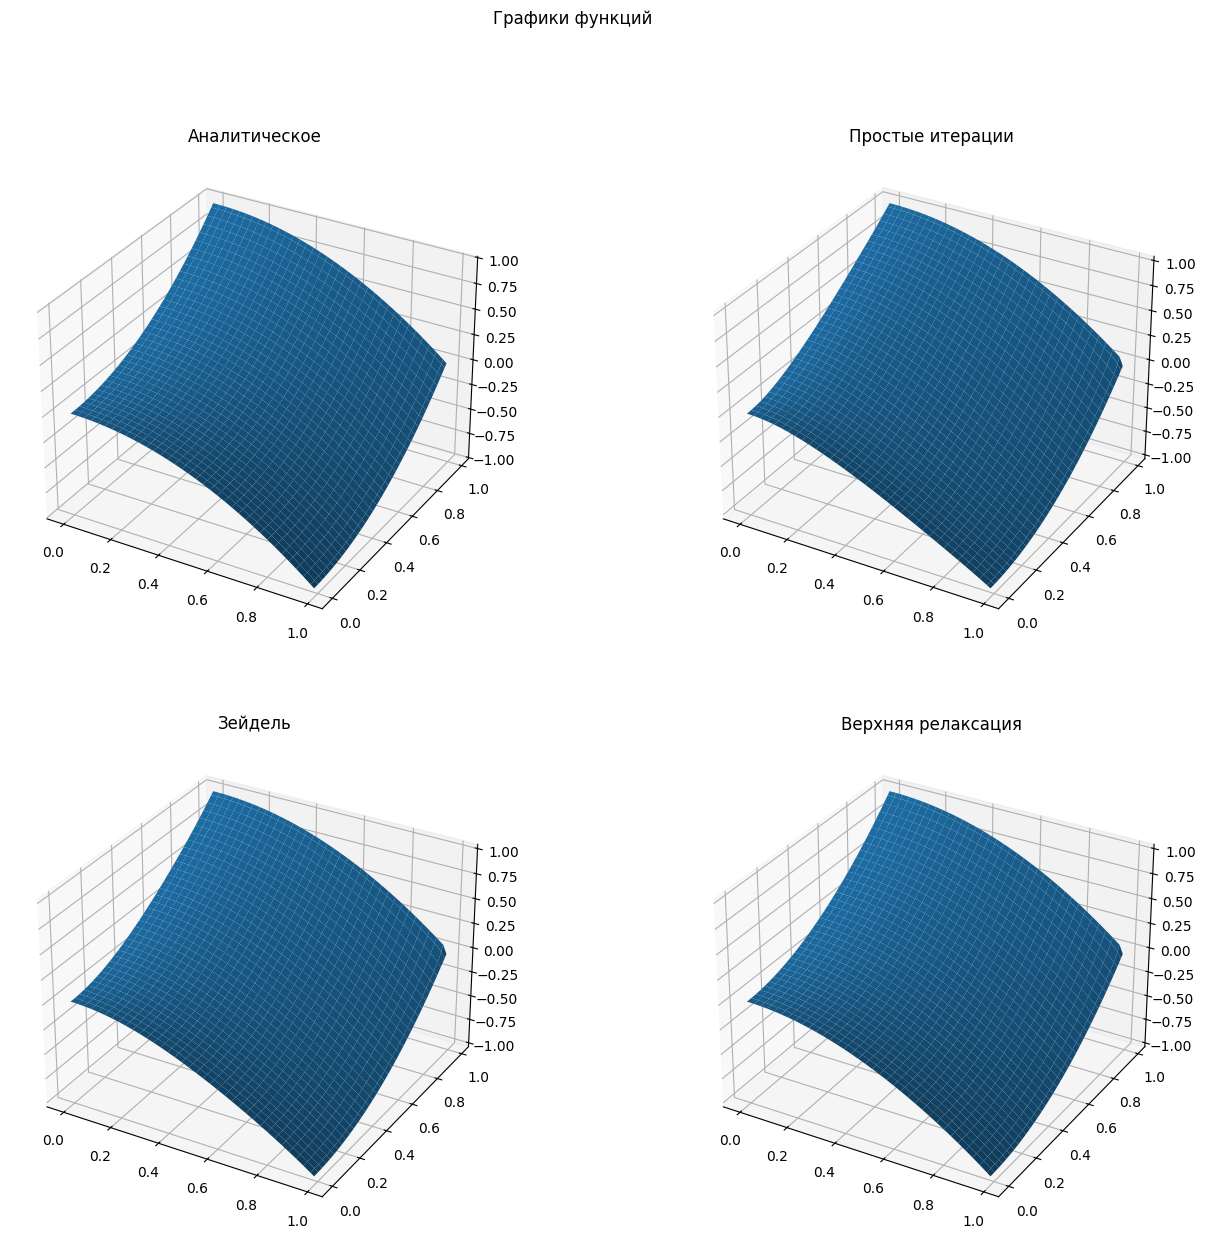

In [6]:
names = ["Аналитическое", "Простые итерации", "Зейдель", "Верхняя релаксация"]
solves = [u, iter, seidel, relax]
iterations = [0, n1, n2, n3]

fig, ax = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='3d'))
fig.suptitle("Графики функций")
ax = ax.ravel()
for idx in range(4):
    ax[idx].set_title(f"{names[idx]}")
    x = np.arange(0, l_x, l_x / N)
    z = np.arange(0, l_y, l_y / K)
    X, Z = np.meshgrid(x, z)
    ax[idx].plot_surface(X, Z, solves[idx])
plt.show()

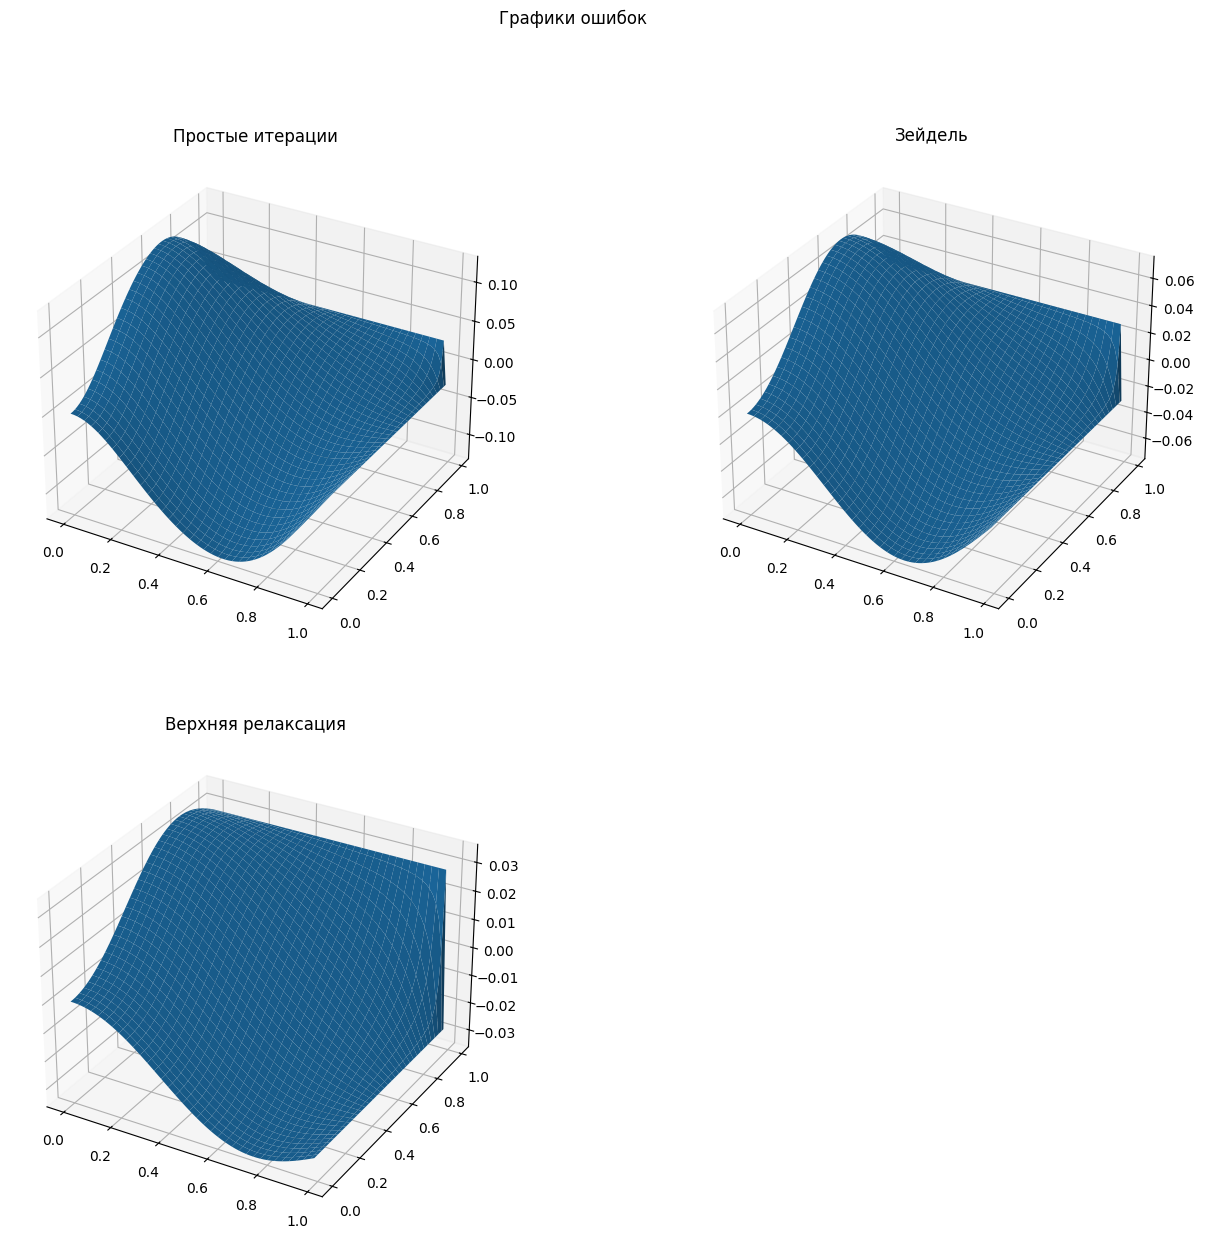

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='3d'))
fig.suptitle("Графики ошибок")
ax = ax.ravel()
for idx in range(1, 4):
    ax[idx - 1].set_title(names[idx])
    x = np.arange(0, l_x, l_x / N)
    z = np.arange(0, l_y, l_y / K)
    X, Z = np.meshgrid(x, z)
    ax[idx - 1].plot_surface(X, Z, solves[idx] - u)
fig.delaxes(ax[3])
plt.show()